# Data Collection for Image Classification

In [2]:
# Importing necessary libraries

import numpy as np
import cv2
import pickle
import os
import shutil
import seaborn as sns
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# ! pip install simple_image_download

from simple_image_download import simple_image_download as simp
response = simp.Downloader

In [6]:
# Downloading Images

names = [ 'ViratKohli', 'KatrinaKaif', 'AliaBhatt', 'Messi', 'Obama']
# for name in names:
# response().download('KatrinaKaif', 200)

## Face Recognition

In [7]:
# Using haar cascades to detect face and eyes in the images

face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')

In [8]:
# Lets define a function to give us a cropped image of faces

def get_cropped_image(path):
    test = cv2.imread(path) # Reading images
    
    if test is not None:
        gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY) # Changing the colored images to gray
        cv2.destroyAllWindows
        faces = face_cascade.detectMultiScale(gray) # Applying face cascade
        
        for (x, y, w, h) in faces:
            face_image = cv2.rectangle(test, (x,y), (x+w, y+h),(0, 255, 0), 2) # Cropping the face
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = test[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray) # Applying the eyes cascade
            
            if len(eyes) > 1: # Using images where more than 1 eye is visible
                for (x1, y1, w1, h1) in eyes:
                    return roi_color

In [9]:
# Using base path to automatically retrieve images

base_path = '.\simple_images'
cropped_image_path = '.\simple_images\cropped_images'

image_dir = []
for folders in os.scandir(base_path):
    image_dir.append(folders.path)

In [10]:
# Creating cropped iamges folder

if os.path.exists(cropped_image_path):
#     os.remove(cropped_image_path)
    shutil.rmtree(cropped_image_path)   # Remove pre-existing cropped image folder
os.mkdir(cropped_image_path)

In [11]:
# Target feature dictionary

target_dict = {} 
count = 0
for image in names:
    target_dict[image] = count
    count += 1

In [12]:
target_dict

{'ViratKohli': 0, 'KatrinaKaif': 1, 'AliaBhatt': 2, 'Messi': 3, 'Obama': 4}

In [13]:
# Saving cropped images into cropped folder

diff_images_dir = []
all_images_dict = {}

for temp in image_dir:
    count = 0    
    name = temp.split('\\')[-1]  # Splitting the name from the folder path
    all_images_dict[name] = []
    
    for data in os.scandir(temp):
        roi = get_cropped_image(data.path)
        if roi is not None:
            cropped_folder = cropped_image_path + '/' + name
            if not os.path.exists(cropped_folder):  # To check if cropped image folder is present
                os.mkdir(cropped_folder)
                diff_images_dir.append(cropped_folder)
                print(f'Generating cropped images in {cropped_folder}')

            crop_image_name = name + str(count) + '.jpeg'
            crop_image_name_path = cropped_folder + '/' + crop_image_name

            cv2.imwrite(crop_image_name_path, roi)
            all_images_dict[name].append(crop_image_name_path)

            count += 1

Generating cropped images in .\simple_images\cropped_images/AliaBhatt
Generating cropped images in .\simple_images\cropped_images/KatrinaKaif
Generating cropped images in .\simple_images\cropped_images/Messi
Generating cropped images in .\simple_images\cropped_images/Obama
Generating cropped images in .\simple_images\cropped_images/ViratKohli


We need to manually delete the images from the cropped folder which can't be used for model

In [28]:
# Defining Wavelet Transform function

import pywt

def w2d(img, mode = 'haar', level = None):
    arr = img
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY) # Converting to grayscale
    arr = np.float32(arr)  # Converting to float
    arr /= 255
    
    # Finding coefficients
    coeff = pywt.wavedec2(arr, mode, level = level)  # Wavelet decomposition
    
    coeff_h = list(coeff)
    coeff_h[0] *= 0
    
    arr_h = pywt.waverec2(coeff_h, mode) # wavelet recomposition
    arr_h *= 255
    arr_h = np.uint8(arr_h)
    
    return arr_h

In [16]:
# Using both the cropped and wavelet transformed image to train the model

resized_images = []
x = []               
y = []

for name in all_images_dict:
    for temp_path in all_images_dict[name]:
        c_img = cv2.imread(temp_path)
        
        if c_img is not None:
            resized_img = cv2.resize(c_img, (150, 150))  # Resizing the image 
            img_har = w2d(c_img, 'db1')                  # Uisng wavelet transform function
            resized_img_har = cv2.resize(img_har, (150, 150))
            
            # Stacking the two images vertically
            stacked_img = np.vstack((resized_img.reshape(150*150*3,1), resized_img_har.reshape(150*150,1)))
            
            resized_images.append(resized_img)  
            x.append(stacked_img)
            y.append(target_dict[name])
            
x = np.array(x).reshape(len(x), 90000).astype(float)  
print(x.shape)

(560, 90000)


# Model Building 

In [17]:
# Splitting the data into train test 

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.25, random_state = 5)
print(x_train.shape)
print(x_test.shape)
len(y_train)
len(y_test)

(420, 90000)
(140, 90000)


140

In [18]:
x_train = x_train/255.0
x_test = x_test/255.0

In [19]:
x_train[0]

array([0.02352941, 1.        , 0.        , ..., 0.30588235, 0.32941176,
       0.33333333])

In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import xgboost

## GridSearch for hyperparameter tuning

### Using multiple algorithms to train the model along with gridsearch to get the hyperparamters

In [21]:
# Initialization of the classifiers

rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
svc = svm.SVC()
lr = LogisticRegression()
xgb = xgboost.XGBClassifier(n_jobs = -1)


model_params = {
                'rfc': {'model': rfc,
                        'params' : {'randomforestclassifier__n_estimators': [10, 50, 100] } },
                'knn': {'model' : knn,
                        'params' : {'kneighborsclassifier__n_neighbors' : [3,5,7] } },
                'svm': {'model': svc, 
                        'params' : {'svc__C': [1,10,100,1000], 'svc__kernel': ['linear', 'poly', 'rbf'] } },
                'lr' : {'model': lr,
                        'params': {'logisticregression__C': [1,3,5,7,10], 'logisticregression__solver': ['newton-cg','liblinear'] } }
                }
                

In [22]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    
    grid_model =  GridSearchCV(pipe, mp['params'], cv = 5 )
    
    grid_model.fit(x_train, y_train)
    
    scores.append({
        'model': algo,
        'best_score': grid_model.best_score_,
        'best_params': grid_model.best_params_
                 })
    best_estimators[algo] = grid_model.best_estimator_
    
df_grid = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df_grid

,model,best_score,best_params
0,rfc,0.940476,{'randomforestclassifier__n_estimators': 100}
1,knn,0.811905,{'kneighborsclassifier__n_neighbors': 3}
2,svm,0.952381,"{'svc__C': 1, 'svc__kernel': 'linear'}"
3,lr,0.961905,"{'logisticregression__C': 1, 'logisticregressi..."


In [23]:
best_estimators

{'rfc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1, kernel='linear'))]),
 'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='newton-cg'))])}

In [24]:
best_estimators['rfc'].score(x_test, y_test)

0.9214285714285714

In [25]:
best_estimators['knn'].score(x_test, y_test)

0.7571428571428571

In [26]:
best_estimators['svm'].score(x_test, y_test)

0.9642857142857143

In [27]:
best_estimators['lr'].score(x_test, y_test)

0.9642857142857143

In [28]:
# Choosing the best estimator 

best_clf = best_estimators['svm']

Text(69.0, 0.5, 'Truth')

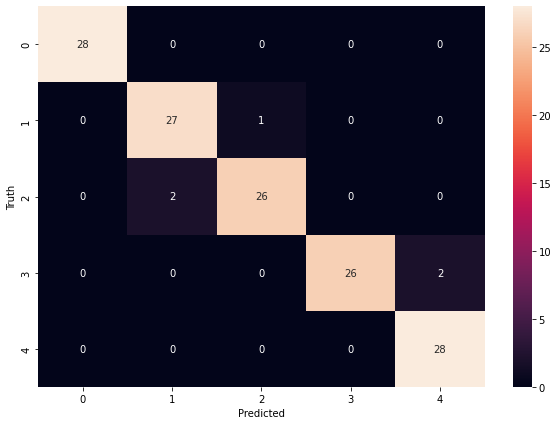

In [29]:
# Generating the Confusion Matrix 

plt.figure(figsize = (10,7))

sns.heatmap(confusion_matrix(y_test, best_clf.predict(x_test)), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
# Save the model as a pickle in a file 
pickle.dump(best_clf, open('final_model.pickle','wb'))

In [31]:
# Saving the target dictionary
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(target_dict))

# Testing the model 

<AxesSubplot:ylabel='count'>

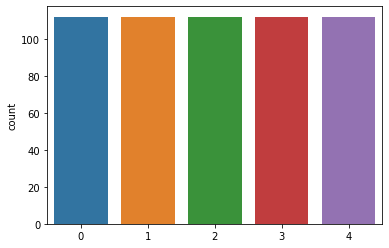

In [32]:
sns.countplot(x = y)

# Model deployment using SVM classifier

Lets use to model to scan through images

The image is of ViratKohli


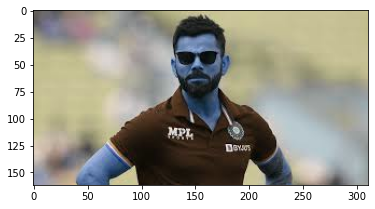

In [103]:
# Accepting the images to predict the name of the celebrity

url = 'C:\\Users\\Admin\\Desktop\\virat2.jpg'
net_img = cv2.imread(url)
plt.imshow(net_img)

faces3 = face_cascade.detectMultiScale(net_img)
for (x3, y3, w3, h3) in faces3:
    exper_img = net_img[y3 :y3+h3, x3 :x3+w3]

exper_img_har1 = w2d(exper_img, 'db1')

resized_img1 = cv2.resize(exper_img, (150, 150))
# stacked_img1 = resized_img1.flatten()
resized_img_har1 = cv2.resize(exper_img_har1, (150, 150))
stacked_img1 = np.vstack((resized_img1.reshape(150 * 150 * 3, 1), resized_img_har1.reshape(150 * 150, 1)))

xyz = np.array(stacked_img1).reshape(1, -1)

result = model_final.predict(xyz)
result = [i for i in target_dict if target_dict[i] == result]
print (f'The image is of {result[0]}')

.

# Let's use CNN for image classification

In [1]:
# Importing deep learning libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

In [18]:
# Resizing and flattening the image array

resized_images_cnn = []
x_cnn = []
y_cnn = []

for name in all_images_dict:
    for temp_path in all_images_dict[name]:
        c_img = cv2.imread(temp_path)
        
        if c_img is not None:
            resized_img = cv2.resize(c_img, (150, 150))
            
            resized_images_cnn.append(resized_img)
            x_cnn.append(resized_img)
            y_cnn.append(target_dict[name])
            

In [19]:
# Splitting the data into train test 

from sklearn.model_selection import train_test_split

x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(x_cnn, y_cnn, stratify = y_cnn, test_size = 0.25, random_state = 5)

In [20]:
# Reshaping the images for cnn model

y_train_cnn = np.array(y_train_cnn).reshape(-1, 1)
y_test_cnn = np.array(y_test_cnn).reshape(-1, 1)
x_train_cnn = np.array(x_train_cnn).reshape(-1, 150, 150, 3)
x_test_cnn = np.array(x_test_cnn).reshape(-1, 150, 150, 3)

In [21]:
# Building a linear stack of layers with the sequential model
cnn_model = Sequential()

# Convolutional layer
cnn_model.add(Conv2D(100, kernel_size=(3,3), strides = (1,1), padding = 'same', activation = 'relu', input_shape = (150, 150, 3)))

# Convolutional layer + Pooling Layer + Dropout
cnn_model.add(Conv2D(175, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(225, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

# Flatten output of conv
cnn_model.add(Flatten())

# Hidden layers
cnn_model.add(Dense(500, activation = 'relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(250, activation = 'relu'))
cnn_model.add(Dropout(0.3))

# Output layer
cnn_model.add(Dense(5, activation = 'softmax'))

# Compiling the sequential model
cnn_model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

# Training the model for 10 epochs
cnn_model.fit(x_train_cnn, y_train_cnn, batch_size = 100, epochs = 10, validation_data = (x_test_cnn, y_test_cnn))


Epoch 1/10
5/5 [==============================] - 239s 46s/step - loss: 1384.2662 - accuracy: 0.1995 - val_loss: 2.7782 - val_accuracy: 0.2708
Epoch 2/10
5/5 [==============================] - 185s 36s/step - loss: 7.3016 - accuracy: 0.2599 - val_loss: 1.6010 - val_accuracy: 0.2500
Epoch 3/10
5/5 [==============================] - 186s 36s/step - loss: 1.5894 - accuracy: 0.2715 - val_loss: 1.6095 - val_accuracy: 0.2153
Epoch 4/10
5/5 [==============================] - 184s 36s/step - loss: 1.5417 - accuracy: 0.3387 - val_loss: 1.5973 - val_accuracy: 0.2708
Epoch 5/10
5/5 [==============================] - 186s 37s/step - loss: 1.4989 - accuracy: 0.3550 - val_loss: 1.5544 - val_accuracy: 0.3403
Epoch 6/10
5/5 [==============================] - 187s 37s/step - loss: 1.3631 - accuracy: 0.4339 - val_loss: 1.4152 - val_accuracy: 0.4444
Epoch 7/10
5/5 [==============================] - 188s 37s/step - loss: 1.0836 - accuracy: 0.5476 - val_loss: 1.0993 - val_accuracy: 0.5625
Epoch 8/10
5/5 [=

In [24]:
pickle.dump(cnn_model, open('cnn_model.pickle','wb'))

INFO:tensorflow:Assets written to: ram://9ab4d8b1-2a43-4962-afef-8d547692ecaf/assets


INFO:tensorflow:Assets written to: ram://9ab4d8b1-2a43-4962-afef-8d547692ecaf/assets


In [22]:
# Viewing the target dicitonary

target_dict

{'ViratKohli': 0, 'KatrinaKaif': 1, 'AliaBhatt': 2, 'Messi': 3, 'Obama': 4}

In [33]:
model_final =  pickle.load(open('final_model.pickle', 'rb'))

In [34]:
model_final

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

1/1 [==============================] - 0s 202ms/step
The image is of ViratKohli with probability of 48.29 %


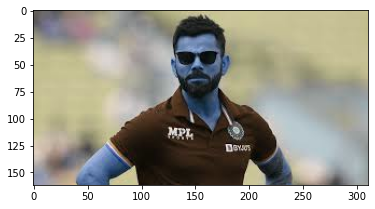

In [111]:
# Accepting the images to predict the name of the celebrity

# url = 'C:\\Users\\Admin\\Desktop\\messi.jpg'
net_img = cv2.imread(url)
plt.imshow(net_img)

faces4 = face_cascade.detectMultiScale(net_img)
for (x4, y4, w4, h4) in faces3:
    exper_img = net_img[y4 :y4+h4, x4 :x4+w4]


resized_img2 = cv2.resize(exper_img, (150, 150))
# stacked_img2 = resized_img2.flatten()

xyz2 = np.array(resized_img2).reshape(-1, 150, 150, 3)

result = cnn_model.predict(xyz2)

result1 = [i for i in target_dict if target_dict[i] == (np.where(result[0] == np.amax(result))[0])]
result_prob = np.round(np.amax(result)*100 ,2)

print (f'The image is of {result1[0]} with probability of {result_prob} %')